In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

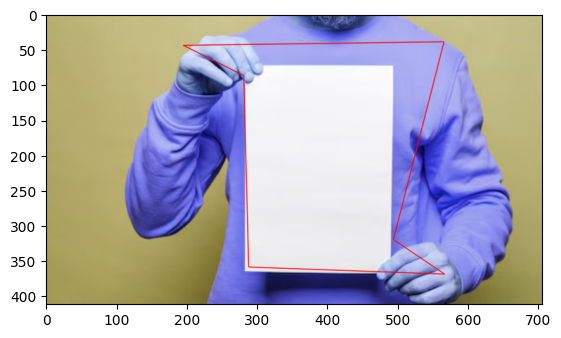

In [2]:
#Method 1: thresholding 

img = cv2.imread('Paper2.png') 

#find image width and height
w,h = img.shape[:2]

#convert image to grayscale
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

#blur image, larger kernel provides closer fit than smaller kernel, but too big a kernel shrinks the paper
blur = cv2.GaussianBlur(gray,(75,75),0)

#threshold image for white
thresh = cv2.threshold(blur,254,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]

#morphological transformation
kernel = np.ones((7,7),np.uint8)
morph = cv2.morphologyEx(thresh,cv2.MORPH_CLOSE, kernel=kernel)
morph = cv2.morphologyEx(morph,cv2.MORPH_OPEN, kernel=kernel)

#find contours, outlines of blurred ROIs 
contours = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

contours = contours[0] if len(contours) == 2 else contours[1]
area_thresh = 0
for c in contours:
    area = cv2.contourArea(c) #find area of the contour
    if area > area_thresh:
        area_thresh = area
        contourMax = c #identify largest contour area -> this should be your paper

paper = np.zeros_like(img)

#draw contour lines on the image using coordinates found in largest contour area
cv2.drawContours(paper,[contourMax], 0, (255,255,255),-1) 

peri = cv2.arcLength(contourMax,True) #parameter for approximation accuracy
#approximate the paper outline with fewer indices, i.e. simplify a more complex shape to rectangle indices
corner = cv2.approxPolyDP(contourMax,0.04*peri, True)

polygon = img.copy()

#overlay the new shape/polygon
cv2.polylines(polygon,[corner],True,(255,0,0),1,cv2.LINE_AA)

plt.imshow(polygon)

# https://stackoverflow.com/questions/60941012/how-do-i-find-corners-of-a-paper-when-there-are-printed-corners-lines-on-paper-i

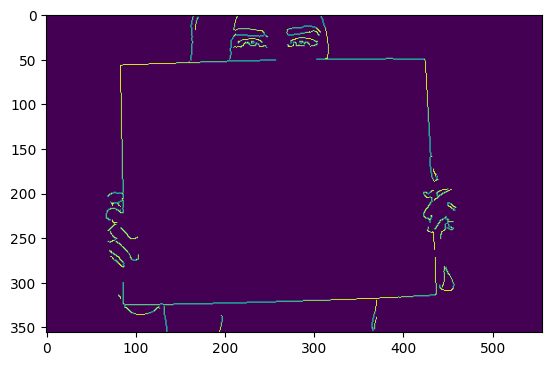

In [34]:
#Identify edges in the image for the next 3 methods 

img = cv2.imread('Paper3.png')

gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

blur = cv2.GaussianBlur(gray,(3,3),0)

edges = cv2.Canny(image=blur,threshold1=100,threshold2=200)

plt.imshow(edges)

In [35]:
#This function identifies the middle/center contour in an image using the identified contours and a specified point
def middle_contour(contours,point):
    min_dist = float('inf')
    closest_contour = None

    for contour in contours:

        dist = cv2.pointPolygonTest(contour,point,True)

        if abs(dist) < min_dist:
            min_dist = abs(dist)
            closest_contour = contour

    return closest_contour

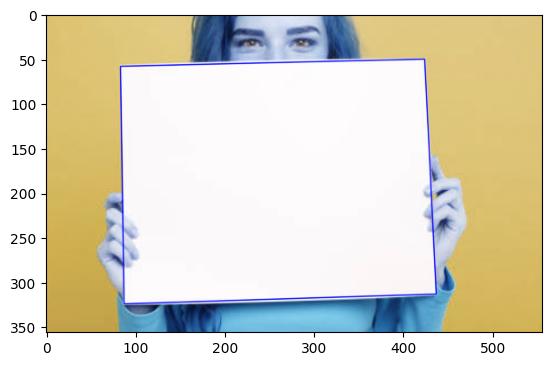

In [36]:
#Method 2: identify center contour of the image 

point = (np.round(w/2),np.round(h/2)) #identify center point of the image using width and height
middle = middle_contour(contours,point) #use middle_contour function

paper = np.zeros_like(img)

#find contours, outlines of blurred ROIs 
cv2.drawContours(paper,[middle], 0, (255,255,255),-1)

peri = cv2.arcLength(middle,True) #parameter for approximation accuracy
#approximate the paper outline with fewer indices, i.e. simplify a more complex shape to rectangle indices
corner = cv2.approxPolyDP(middle,0.04*peri, True) 

polygon = img.copy()

#overlay the new shape/polygon
cv2.polylines(polygon,[corner],True,(0,0,255),1,cv2.LINE_AA)

plt.imshow(polygon)

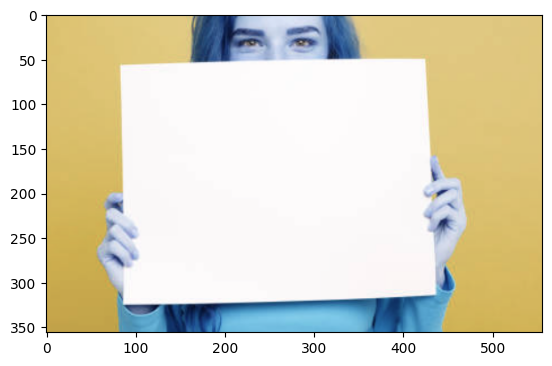

In [37]:
#Method 3: Identify most rectangular contours 

rectangles = []

for contour in contours:
    epsilon = 0.02 * cv2.arcLength(contour,True) #parameter for approximation accuracy
#approximate the paper outline with fewer indices, i.e. simplify a more complex shape to rectangle indices
    approx = cv2.approxPolyDP(contour,epsilon,True)

    if len(approx) == 4: #identifies 4-sided contours

        rectangles.append(approx)

for rect in rectangles:
    #find contours, outlines of blurred ROIs 
    cv2.drawContours(paper,[rect], -1, (255,255,255),2)

peri = cv2.arcLength(rect,True) #parameter for approximation accuracy
#approximate the paper outline with fewer indices, i.e. simplify a more complex shape to rectangle indices
corner = cv2.approxPolyDP(rect,0.04*peri, True)

polygon = img.copy()

#overlay the new shape/polygon
cv2.polylines(polygon,[corner],True,(0,0,255),1,cv2.LINE_AA)

plt.imshow(polygon)

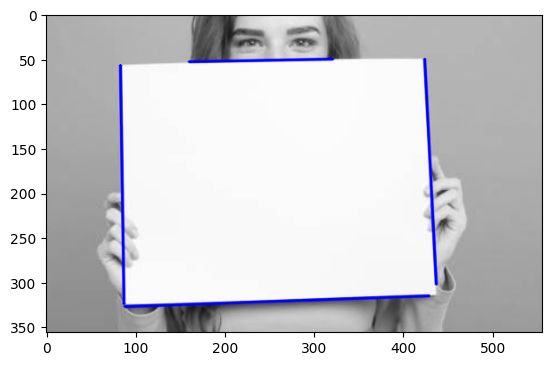

In [38]:
#Method 4: Identify Hough Lines 

imgC = cv2.cvtColor(gray,cv2.COLOR_GRAY2BGR)

lines = cv2.HoughLinesP(edges, 1, np.pi/180,100,minLineLength=100,maxLineGap=50) #probabilistic Hough Transform
#can adjust min line length, max line gap, need to consider how much paper covers screen and overlap with hands holding paper

for line in lines:
        x1,y1,x2,y2 = line[0] #pull out all line indices

        #draw lines on image
        cv2.line(imgC, (x1,y1),(x2,y2), (0,0,255),2, cv2.LINE_AA)

plt.imshow(imgC)

In [39]:
#This function identifies the dominant color in an image, which ideally is white when the paper covers the majority of the frame 

def segment_dominant_color(img,k=3):
    #reshape image into 2D array
    pixels = img.reshape((-1,3))
    pixels = np.float32(pixels)

    #define criteria for k-means clustering
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,10,1.0)

    #apply k-means clustering
    _,labels,centers = cv2.kmeans(pixels,k,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

    #convert labels back to original image
    labels = labels.reshape(img.shape[:2])

    #create mask for dominant color
    dominant_color_mask = np.where(labels == 0,255,0).astype(np.uint8)

    return dominant_color_mask


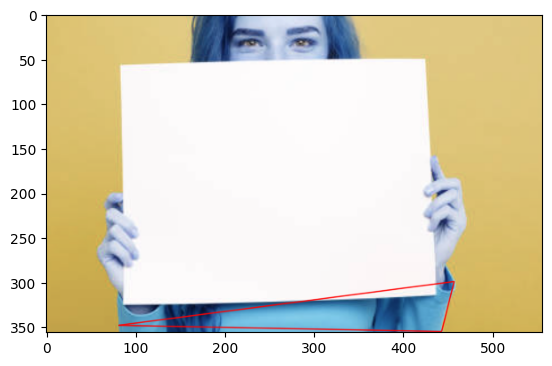

In [40]:
#Method 5: Segment by dominant color

img = cv2.imread('Paper3.png') 

dominant_color_mask = segment_dominant_color(img) #find dominant color mask

#morphological transformation
kernel = np.ones((7,7),np.uint8)
morph = cv2.morphologyEx(dominant_color_mask,cv2.MORPH_CLOSE, kernel=kernel)
morph = cv2.morphologyEx(dominant_color_mask,cv2.MORPH_OPEN, kernel=kernel)

#find contours, outlines of blurred ROIs 
contours = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

contours = contours[0] if len(contours) == 2 else contours[1]
area_thresh = 0
for c in contours:
    area = cv2.contourArea(c) #find area of the contour
    if area > area_thresh:
        area_thresh = area
        contourMax = c #identify largest contour area -> this should be your paper

paper = np.zeros_like(img)

#draw contour lines on the image using coordinates found in largest contour area
cv2.drawContours(paper,[contourMax], 0, (255,255,255),-1) 

peri = cv2.arcLength(contourMax,True) #parameter for approximation accuracy
#approximate the paper outline with fewer indices, i.e. simplify a more complex shape to rectangle indices
corner = cv2.approxPolyDP(contourMax,0.04*peri, True)

polygon = img.copy()

#overlay the new shape/polygon
cv2.polylines(polygon,[corner],True,(255,0,0),1,cv2.LINE_AA)

plt.imshow(polygon)